# Проект: Классификация текстов


## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

## Задача

Созадть модель классификации комментариев на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества F1 не меньше 0.75.

## Техническое задание 

1. Загрузка и знакомство с данными
    - Проверка на наличие пропусков и дубликатов
2. Подготовка данных
    - Лемматизация текста
3. Кросс-валидация
    - Создать пайплайны
    - Протестировать различные модели на кросс валидации, выбрать лучшую
4. Проверка модели на тесте
    - Проверить модель на тестовых данных
    - Проинтерпретировать модель

## Все необходимые загрузки и импорты

In [1]:
import sys

!{sys.executable} -m pip install spacy==3.2.6
!{sys.executable} -m spacy download en


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 13.9/13.9 MB 173.4 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import re
import time
import spacy
import nltk

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm_notebook as tqdm

from spacy.lang.en.stop_words import STOP_WORDS

from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier


nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = set(STOP_WORDS)
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42




[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Загрузка данных и EDA

In [3]:
try:
    data = pd.read_csv('datasets/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')
    
data.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Удалим непонятный столбец дублирующий индексы, скорее всего он добавлен случайно.

In [4]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Проверим типы даннх, пропуски и дубликаты

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
print(f'Число дубликатов в данных: {data.duplicated().sum()}')

Число дубликатов в данных: 0


Пропусков и дубликатов в данных нет типы данных соответствуют значениям в столбцах. Посмотрим на респределение наших классов.

In [7]:
data.value_counts('toxic')

toxic
0    143106
1     16186
dtype: int64

Классы не сбалансированны, поэтому лучше всего ипользовать метрику f1, так как она это учитывает. Можно переходить к предобработке данных. Создадим функцию которая делает лемматизацию текстов. И создадим корпус текстов.

## Предобработка данных

In [10]:
def words_only(text):
    return ' '.join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())


def lemmatize_text(text, nlp):
    return [token.lemma_ for token in nlp(text)]


def remove_stopwords(text, stopwords):
    return [word for word in text if not word in stopwords and len(word) > 1]


def clean_text(text, nlp, stopwords):

    text_words = words_only(text)
    
    text_lemmas = lemmatize_text(text_words, nlp)
    
    return ' '.join(remove_stopwords(text_lemmas, stopwords))


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

corpus = []

for i in tqdm(range(len(data))):
    corpus.append(clean_text(data['text'][i], nlp, stop_words))
    
corpus[0]

  0%|          | 0/159292 [00:00<?, ?it/s]

'explanation edit username hardcore metallica fan revert weren vandalism closure gas vote new york doll fac don remove template talk page retire'

In [12]:
corpus = pd.Series(corpus)

X_train, X_test, y_train, y_test = train_test_split(corpus,
                                                    data['toxic'],
                                                    test_size=0.1,
                                                    random_state=RANDOM_STATE)

X_train.head()

74250     stop delete image consult quadell need stop delete image consulting person post bad behavior cease desist think problem discuss person involve don matter hand action disrespect people angry ledastray
101310                                                                                      controversial material kind unsourced poorly source remove immediately especially potentially libelous blp rule apply
147342                                                 image source info hi clear cat ns come image image eichmann trial glass box jpg upload possible provide source info win delete csd later date sorry bother
90758                                                             extra stuff reduce article size fourth item series request vote section ready aren need address area discuss vote thing unnecessary fluff bloat
127220                                                                                                                                                          

### Вывод по предобработке данных
Данные лематизированны, можно переходить к созданию пайплайнов и проверке моделей на кросс-валидации. Векторизцию встрим уже в пайплайн. 

## Кросс-валидация

### LogisticRegression

In [13]:
cv_params = {'scoring': 'f1',
             'return_train_score': True,
             'cv': 5}


In [14]:
%%time
pipe = Pipeline([('vectorizer', TfidfVectorizer(min_df=1e-5)),
                 ('model', LogisticRegression(class_weight='balanced', 
                                            random_state=RANDOM_STATE, 
                                            max_iter=500))
                ])
params_grid = [
    {
        'vectorizer__ngram_range' : [(1, 1), (1, 2)],
        'model__C' : [0.1, 1, 10]
    },
]

gs_linear = GridSearchCV(
    pipe,
    params_grid,
    **cv_params,
    n_jobs=-1
)

gs_linear.fit(X_train, y_train)
print(f'Лучшая метрика f1 на кросс-валидации : {round(gs_linear.best_score_, 2)}')
print(f'Параметры лучшей модели: {gs_linear.best_estimator_}')

Лучшая метрика f1 на кросс-валидации : 0.78
Параметры лучшей модели: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=1e-05, ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=500,
                                    random_state=42))])
Wall time: 3min 30s


In [15]:
linear_model_info = (
    pd.DataFrame(gs_linear.cv_results_)
    [[
        'params', 
        'mean_test_score',
        'rank_test_score',
        'mean_fit_time', 
        'mean_score_time'
    ]]
    .sort_values(by='mean_test_score', ascending=False)
)

linear_model_info.head()

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
5,"{'model__C': 10, 'vectorizer__ngram_range': (1, 2)}",0.783833,1,80.432687,2.710648
3,"{'model__C': 1, 'vectorizer__ngram_range': (1, 2)}",0.757134,2,56.840622,4.326958
4,"{'model__C': 10, 'vectorizer__ngram_range': (1, 1)}",0.754550,3,21.645838,1.442180
2,"{'model__C': 1, 'vectorizer__ngram_range': (1, 1)}",0.749696,4,10.024528,1.713953
0,"{'model__C': 0.1, 'vectorizer__ngram_range': (1, 1)}",0.716991,5,8.078571,1.452796


### LGBMClassifier

In [16]:
%%time
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=1e-5)),
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

params_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__num_leaves': [2, 5, 7, 12]
}

gs_lgbm = GridSearchCV(
    pipe,
    params_grid,
    **cv_params,
    n_jobs=-1
)
gs_lgbm.fit(X_train, y_train)
print(f'Лучшая метрика f1 на кросс-валидации : {round(gs_lgbm.best_score_, 2)}')
print(f'Параметры лучшей модели{gs_lgbm.best_estimator_}')

Лучшая метрика f1 на кросс-валидации : 0.75
Параметры лучшей моделиPipeline(steps=[('vectorizer', TfidfVectorizer(min_df=1e-05)),
                ('model',
                 LGBMClassifier(n_estimators=300, num_leaves=12,
                                random_state=42))])
Wall time: 10min 36s


In [17]:
boosting_model_info = (
    pd.DataFrame(gs_lgbm.cv_results_)
    [[
        'params',
        'mean_test_score',
        'rank_test_score',
        'mean_fit_time',
        'mean_score_time'
     ]]
    .sort_values(by='mean_test_score', ascending=False)
)

boosting_model_info.head()

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
15,"{'model__n_estimators': 300, 'model__num_leaves': 12}",0.751698,1,121.483588,1.582279
11,"{'model__n_estimators': 200, 'model__num_leaves': 12}",0.737137,2,113.975555,1.992502
14,"{'model__n_estimators': 300, 'model__num_leaves': 7}",0.725694,3,123.587897,1.917860
10,"{'model__n_estimators': 200, 'model__num_leaves': 7}",0.701447,4,88.266450,2.022047
13,"{'model__n_estimators': 300, 'model__num_leaves': 5}",0.700884,5,100.518000,2.147936


#### Вывод по кросс-валидации

Лучшей моелью на этапе кросс-валидации оказалась модель логистической регрессии. Ее точность даже выше чем у модели градиентного бустинга. Можно проверить результат ее работы на тестовой выборке.

## Проверка модели на тестовых данных

In [18]:
model = gs_linear.best_estimator_.fit(X_train, y_train)
predictions = model.predict(X_test)
f1_linear = f1_score(y_test, predictions)
print(f'Метрика f1 на тестовой выборке равна: {round(f1_linear, 2)}')

Метрика f1 на тестовой выборке равна: 0.8


Отлично метрика даже не упала и она соответствует условию задачи. Модель работает достаточно точно.

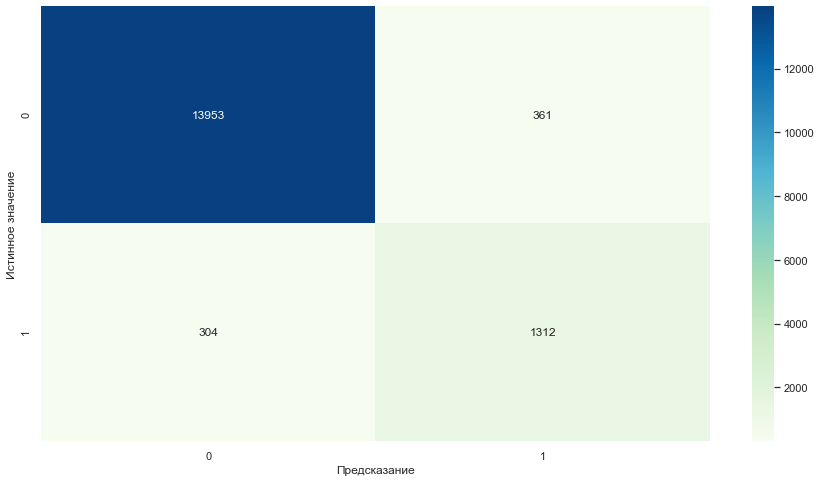

In [19]:
cm = confusion_matrix(y_test, predictions)
sns.set()
plt.figure(figsize=(15,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказание');

Модель лучше предсказывает нетокстичные комментарии, но с пердсказанием токсичных она тоже справляется неплохо, учитывая, что их в разы меньше. Модель совершает ошибку первого и второго рода в примерно одинаковое количество раз.

## Вывод по проделанной работе

1. Были предоставлены данные достаточно высокого качества, в них небыло дубликатов и пропусков, на этапе EDA был удален только ненужный столбец, который скорее всего попал в данные случайно.

2. На этапе предобработки данных комментарии были лемматизированны, векторизация данных прводится на этапе кросс валидации, чтобы при помощи пайплайна подобрать лучший размер n-грамм.

3. На этапе кросс-валидации была проверена моель LogisticRegression и LGBMClassifier, для них при помощи GridSearchCV подбирались лучшие гиперпараметры. По результатам кросс валидации была выбрана лучшая модель ей оказалась моель логисической регрессии.

4. На этапе проверки модели на тестовых данных моедль была протестированна на тестовом наборе, ее метрика f1 удовлетворяет условию задачи и не спадает с этапа кросс-валидации. Изучена матрица ошибок лучшей модели, модель совершает ошибку первого и вторго рода примерно в одинаковом количестве случаев.